In [1]:
import itertools

import matplotlib.pyplot as plt

from minitorch.autodiff import Scalar
import minitorch.autodiff.tensor_functions as tf
import minitorch.datasets as data
from minitorch.module import LinearScalarLayer, LinearTensorLayer, ScalarNetwork, TensorNetwork
from minitorch.optim import SGDOptimizer
import minitorch.scalar_metrics as sm
import minitorch.scalar_losses as sl
import minitorch.tensor_losses as tl
import minitorch.tensor_metrics as tm
from minitorch.plotting import plot_scalar_predictions

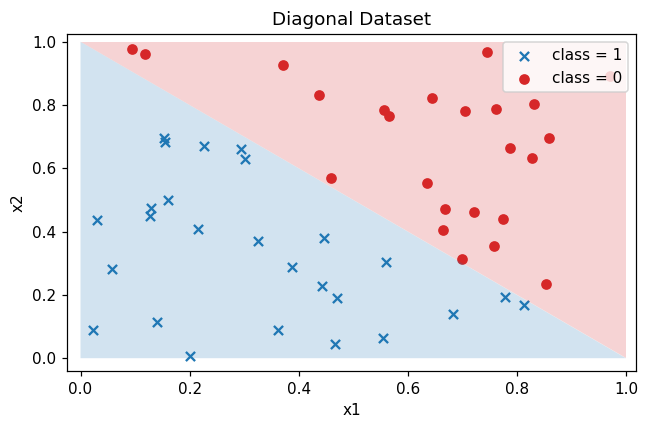

In [2]:
# Create a dataset
N_SAMPLES = 50
dataset = data.DiagonalDataset(N_SAMPLES)
dataset.plot();

### Scalars

In [3]:
# Create a linear layer
network = LinearScalarLayer(input_dim=2, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.75)

# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [4]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))

    # Compute a loss
    loss_per_epoch = sl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

    if epoch + 1 == n_epochs:
        print(f"epoch {epoch + 1}: loss = {loss_per_epoch.data}")

epoch 0: loss = 0.7222224642649037
epoch 10: loss = 0.6351355124282978
epoch 20: loss = 0.5839338519629882
epoch 30: loss = 0.54182174149108
epoch 40: loss = 0.5068166798583231
epoch 50: loss = 0.4773948076943514
epoch 60: loss = 0.4523845020785182
epoch 70: loss = 0.43089110494977
epoch 80: loss = 0.41223058640639315
epoch 90: loss = 0.3958768098874885
epoch 100: loss = 0.3814216014170863
epoch 110: loss = 0.36854517753541427
epoch 120: loss = 0.35699442052317865
epoch 130: loss = 0.3465669205287594
epoch 140: loss = 0.3370992019128001
epoch 150: loss = 0.32845797583511654
epoch 160: loss = 0.32053358660021497
epoch 170: loss = 0.3132350569898737
epoch 180: loss = 0.3064863075646008
epoch 190: loss = 0.3002232450224889
epoch 200: loss = 0.29495664320674253


In [5]:
# Metrics
y_true = [Scalar(y_t) for y_t in y_true]
y_hat = [[scalar.sigmoid() for scalar in row] for row in network.forward(X)]
y_hat = list(itertools.chain.from_iterable(y_hat))

# Convert to classes using 0.5 threshold
y_hat_classes = [Scalar(1.0) if proba.data >= 0.5 else Scalar(0.0) for proba in y_hat]

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [sm.accuracy, sm.precision, sm.recall]
}

{'accuracy': Scalar(1.000, name=None),
 'precision': Scalar(1.000, name=None),
 'recall': Scalar(1.000, name=None)}

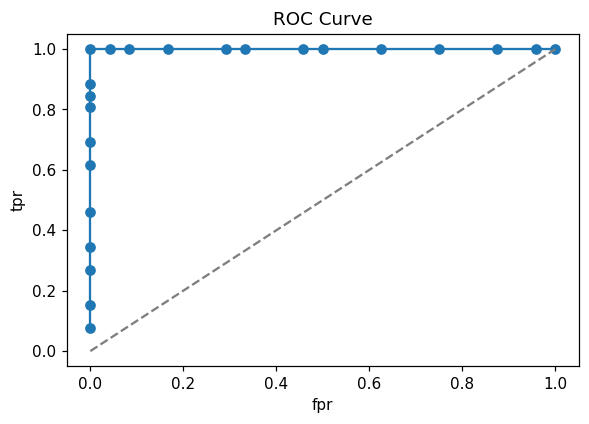

In [6]:
# ROC Curve
tpr, fpr, thresholds = sm.roc_curve(y_true, y_hat, bucket_size=0.025)
tpr, fpr = [s.data for s in tpr], [s.data for s in fpr]

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve");

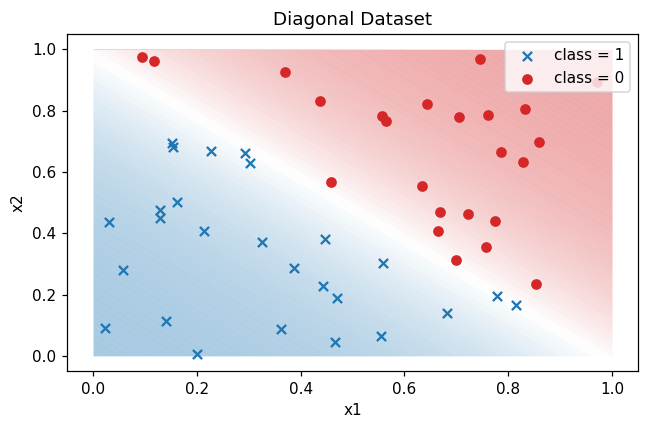

In [7]:
# Visualising predictions
plot_scalar_predictions(dataset, network);

### Tensors

In [ ]:
# Create a linear layer
network = TensorNetwork(input_dim=2, hidden_dim=5, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.5)

# Data
X = tf.tensor([list(x) for x in dataset.xs])
y_true = tf.tensor(dataset.ys).view(N_SAMPLES, 1)

In [ ]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X).sigmoid()

    # Compute a loss
    loss_per_epoch = tl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.item())
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.item()}")

    if epoch == (n_epochs - 1):
        print(f"epoch {epoch + 1}: loss = {loss_per_epoch.item()}")

In [ ]:
# Metrics
y_true = y_true.view(y_true.size)
y_hat = network.forward(X).sigmoid()
y_hat_classes = (y_hat >= 0.5).view(y_hat.size)

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [tm.accuracy, tm.precision, tm.recall]
}

In [ ]:
# ROC Curve
y_true = y_true.view(y_true.size)
y_hat = y_hat.view(y_hat.size)

tpr, fpr, thresholds = tm.roc_curve(y_true, y_hat, bucket_size=0.001)
tpr, fpr = tpr.data.storage, fpr.data.storage

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve")
fig.tight_layout();